# Lecture5 并发编程
## 一、多进程、多线程运行与交互
### 1.并发
* 程序要同时处理多个任务
* 经常需要等待资源响应
* 多系统分时协作任务
#### 例子
* 游戏：同时显示场景、播放声音、响应用户输入
* 网络服务器：同时与多个客户端建立连接、处理请求
* 多个功能化例程协作完成任务
#### 实现方法
* 并行：如多核CPU不同核上跑的两个进程。两个计算流在时间上重叠
* 并发：如单核CPU上跑的两个进程。两个计算流在时间上交替执行。给我们带来宏观上两个进程同时运行的假象
### 2.计算机如何执行程序
* 内核负责资源的调度
* 每个进程有独立的逻辑控制流、私有的虚拟地址空间
* 维护一个进程需要——进程的上下文
    * 程序计数器、通用目的寄存器、浮点寄存器、状态寄存器
    * 用户栈、内核栈、内核数据结构（用来映射虚拟地址的页表、当前打开文件信息的文件表）
* 具体执行中是通过进程头与CPU的寄存器组配合保留-恢复进程的私有运行环境
#### 程序执行时的私有环境
* 程序计数器
    * 控制读到哪一句
* 通用目的寄存器、浮点寄存器、条件码寄存器
    * 存某些变量的值、中间计算结果、栈指针、子程序返回值...
### 3.内核、进程与线程
#### 内核：分时调度和共享资源
* 内核负责进程的挂起和唤醒
    * 在进程执行期间进行上下文的切换
#### 进程
* 虚拟地址空间独立运行。其资源被内核保护起来
#### 线程
* 进程之间不共享内存，进程的切换-协同效率低
* 线程（thread）：调度执行的最小单元
    * 每个线程运行在单一进程中
    * 一个进程中可以有多个线程
* 线程上下文
    * 程序计数器、通用目的寄存器、浮点寄存器、条件码
    * 线程ID，栈，栈指针
* 线程间可以共享进程空间的公有数据：进程打开的文件描述符、信号锁、处理器、进程的当前目录和进程用户ID与进程组ID。因此可以方便的进行通讯
### 4.多进程与多线程
#### 多进程
* 程序之间不共享内存，使用虚拟地址映射保证资源独立
* 优点：一个进程挂了不影响别的进程
* 缺点：切换上下文效率低，通信和信息共享不太方便
#### 多线程
* 优点：上下文切换效率比多进程高，线程之间信息共享和通信方便
* 缺点：一个线程挂了会使整个进程挂掉。操作全局变量需要锁机制
#### 总结
* 不同的进程、线程之间总是并发/并行的
    * 如果运行在多核CPU不同的核上，是可以并行的
#### 补充：线程锁机制
* 多个逻辑控制流同时读写共享的资源时，需要加入锁机制
* 例：100个线程，每个都对一个全局变量cnt不加锁操作cnt+=1，执行完后结果≤100
* 加锁
    * 需要读写某个共享变量时，读写前上锁，读写后释放锁
    * 如果要读写的共享变量上了锁，等待锁释放后再上锁读写
### 5.python中的多进程模式：Process对象
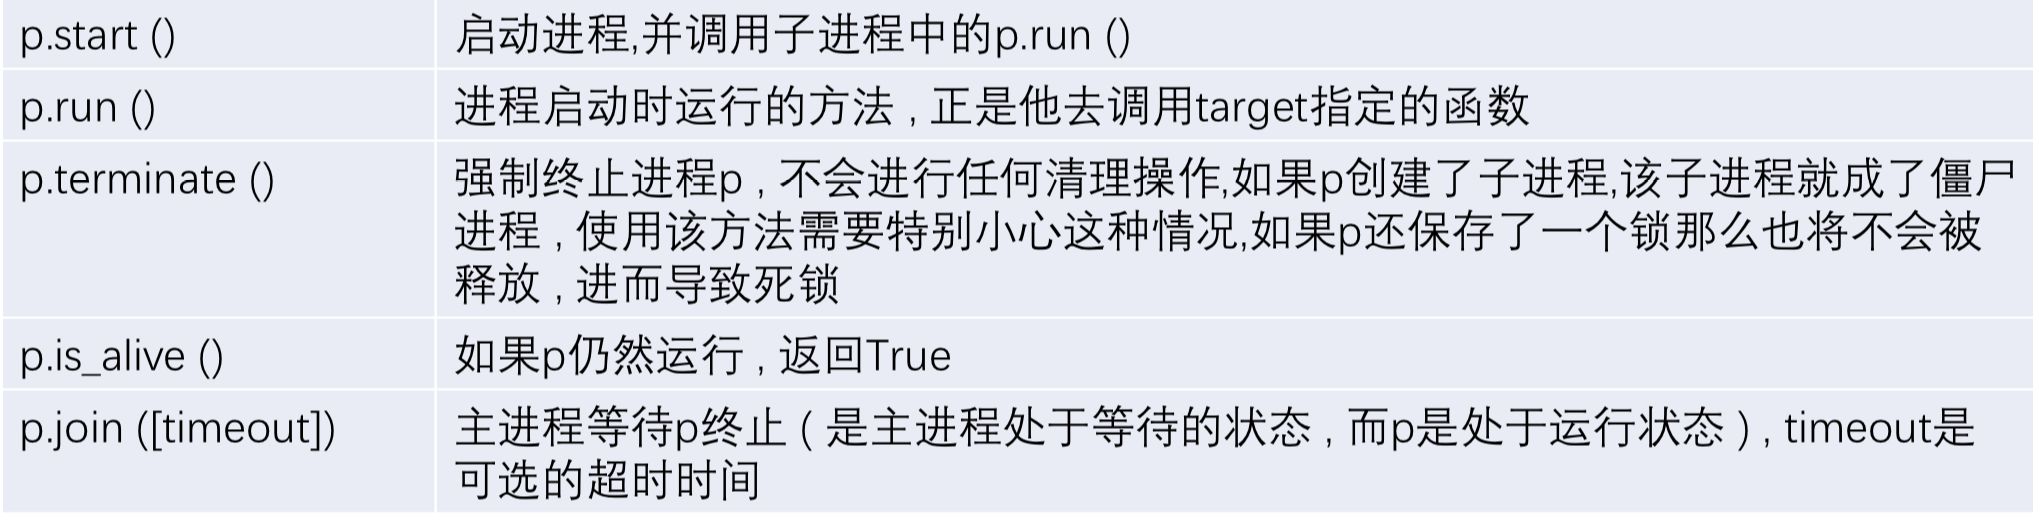

In [1]:
%%writefile multi_process.py
import time
from multiprocessing import Process

def func():
    time.sleep(3)
    print("Child process done.")

if __name__ == '__main__':
    __spec__ = None # 为了能够运行多次，Jupyter中运行多进程程序不太方便
    p = Process(target = func)
    p.start()
    time.sleep(2)
    p.join() # 阻塞，等待子进程
    print("Parent process done.")

Overwriting multi_process.py


In [3]:
%run multi_process.py

Child process done.
Parent process done.


In [4]:
%%writefile multi_process.py
import os
import time
from multiprocessing import Process

def hello(i):
    print('Child process id {} - for task {}'.format(os.getpid(), i))
    time.sleep(2)

if __name__ == '__main__':
    __spec__ = None # 为了能够运行多次，Jupyter中运行多进程程序不太方便
    start = time.time()
    p1 = Process(target = hello, args = (1, )) # 传递参数
    p2 = Process(target = hello, args = (2, )) # 传递参数
    p1.start()
    p2.start()
    p1.join()
    p2.join()
    end = time.time()
    print('Totally take {} seconds.'.format(end - start))

Overwriting multi_process.py


In [5]:
%run multi_process.py

Child process id 67789 - for task 1
Child process id 67790 - for task 2
Totally take 2.0476770401000977 seconds.


### 6.多进程池
* 用于并发计算资源共享
* 进程池
    * 定义一个池子, 在里面放上固定数量的进程, 有任务要处理的时候就会拿一个池中的进程来处理任务, 等到处理完毕, 进程并不关闭而是放回进程池中继续等待任务
    * 如果很多任务需要执行, 池中的进程数不够, 任务会就要等待拿到空闲的进程才继续执行
* `multiprocessing.Pool`
    * `Pool([numprocess[ ,initializer [, initargs] ] ])`：创建进程池
    * 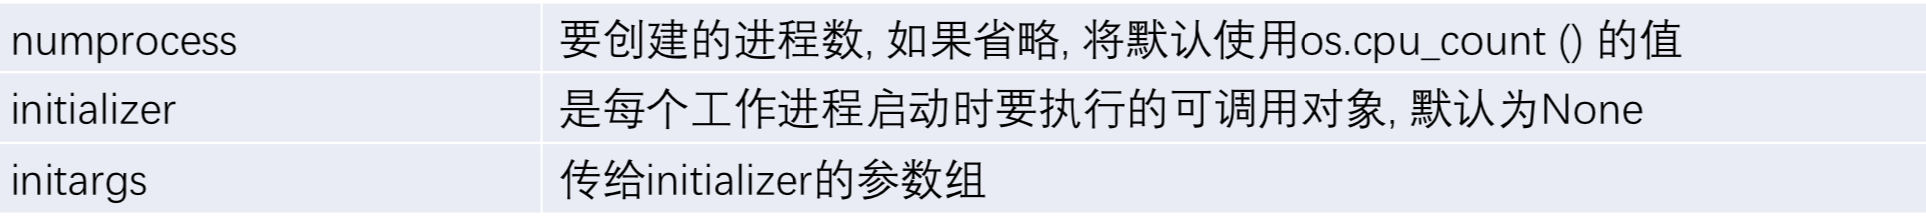
    * 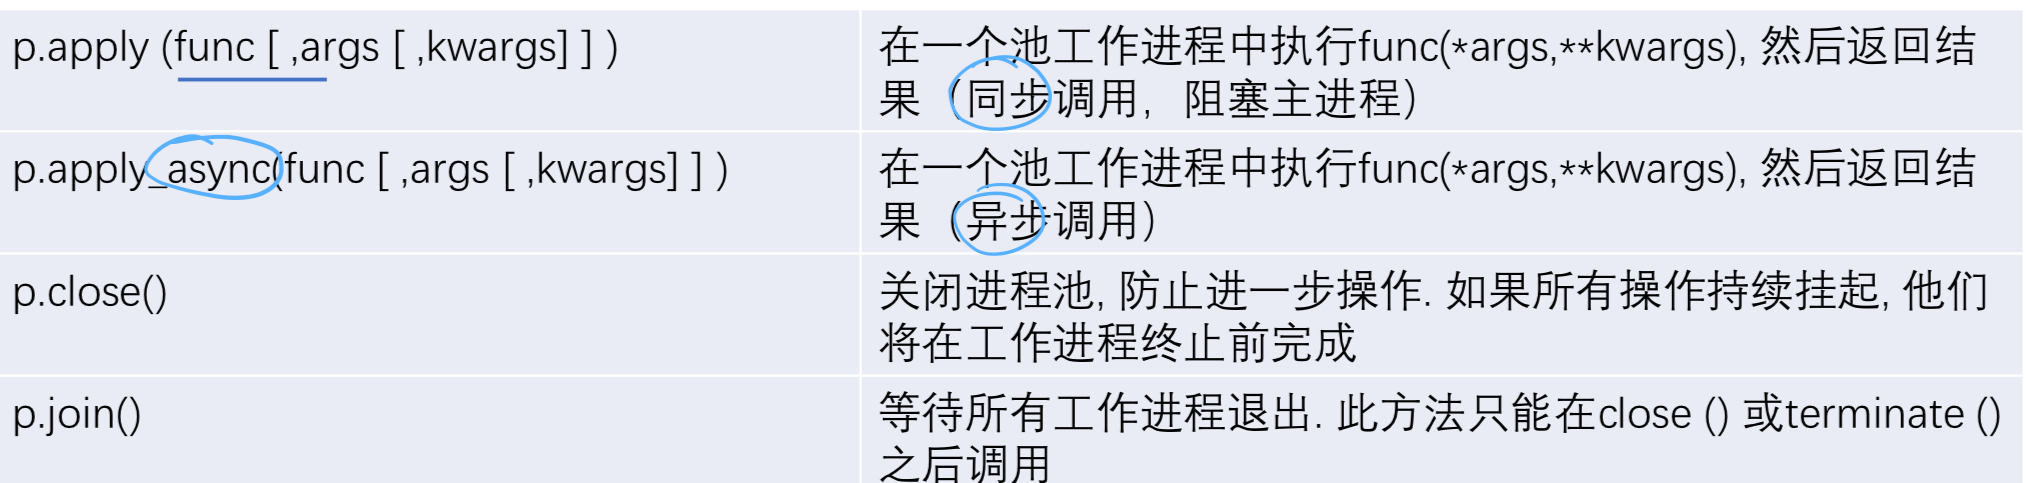

In [5]:
%%writefile multi_process.py
import os
import time
from multiprocessing import Process, Pool

def hello(i):
    print('Child process id {} - for task {}'.format(os.getpid(), i))
    time.sleep(2)

if __name__ == '__main__':
    __spec__ = None # 为了能够运行多次，Jupyter下运行多进程程序不太方便
    start = time.time()
    p = Pool(4) # 开4个进程
    for i in range(5): # 第五个进程需要等待
        p.apply_async(hello, args = (i, )) # 异步运行
    p.close() # 不再接收新的进程
    p.join() # 等待池中所有进程结束
    end = time.time()
    print('Totally take {} seconds.'.format(end - start))

Overwriting multi_process.py


In [6]:
%run multi_process.py

Child process id 69319 - for task 0
Child process id 69320 - for task 1
Child process id 69321 - for task 2
Child process id 69322 - for task 3
Child process id 69319 - for task 4
Totally take 4.0608909130096436 seconds.


In [7]:
%%writefile multi_process.py
import os, time, random
from multiprocessing import Process, Pool

def long_time_task(name):
    print('Run task %s (%s)...' % (name, os.getpid()))
    start = time.time()
    time.sleep(random.random() * 3)
    end = time.time()
    print('Task %s runs %0.2f seconds.' % (name, end - start))

if __name__ == '__main__':
    __spec__ = None
    print('Parent process %s.' % os.getpid())
    p = Pool(4)
    for i in range(5):
        p.apply_async(long_time_task, args = (i, ))
    print('Waiting for all subprocesses done...')
    p.close()
    p.join()
    print('All subprocesses done.')

Overwriting multi_process.py


In [8]:
%run multi_process.py

Parent process 68309.
Waiting for all subprocesses done...
Run task 0 (69691)...
Run task 1 (69692)...
Run task 2 (69693)...
Run task 3 (69694)...
Task 2 runs 1.63 seconds.
Run task 4 (69693)...
Task 3 runs 2.06 seconds.
Task 0 runs 2.35 seconds.
Task 1 runs 2.67 seconds.
Task 4 runs 2.48 seconds.
All subprocesses done.


### 7.进程间通讯
* 两个进程传递消息，可以使用Pipe()。多个进程间共享消息或数据可以采用队列Queue（允许多个生产者和消费者）
    * 尽量避免自己设计资源锁进行同步
 * multiprocessing使用queue.Empty和queue.Full异常
 * Queue 有两个方法，get 和 put （可以设定阻塞或非阻塞）
#### Pipe
* Pipe()返回一个由管道连接的连接对象，默认情况下是双工（双向）的

In [10]:
%%writefile multi_process.py
from multiprocessing import Process, Pipe

def f(conn):
    conn.send([42, None, 'hello'])
    print(conn.recv()) # 阻塞，等待消息
    conn.close()

if __name__ == '__main__':
    __spec__ = None
    parent_conn, child_conn = Pipe() # 类似于buffer的功能
    p = Process(target = f, args = (child_conn, ))
    p.start()
    print(parent_conn.recv()) # 阻塞，等待消息
    parent_conn.send('Hi')
    p.join()

Overwriting multi_process.py


In [11]:
%run multi_process.py

[42, None, 'hello']
Hi


#### Queue
* Queue 是一个近似 queue.Queue 的克隆
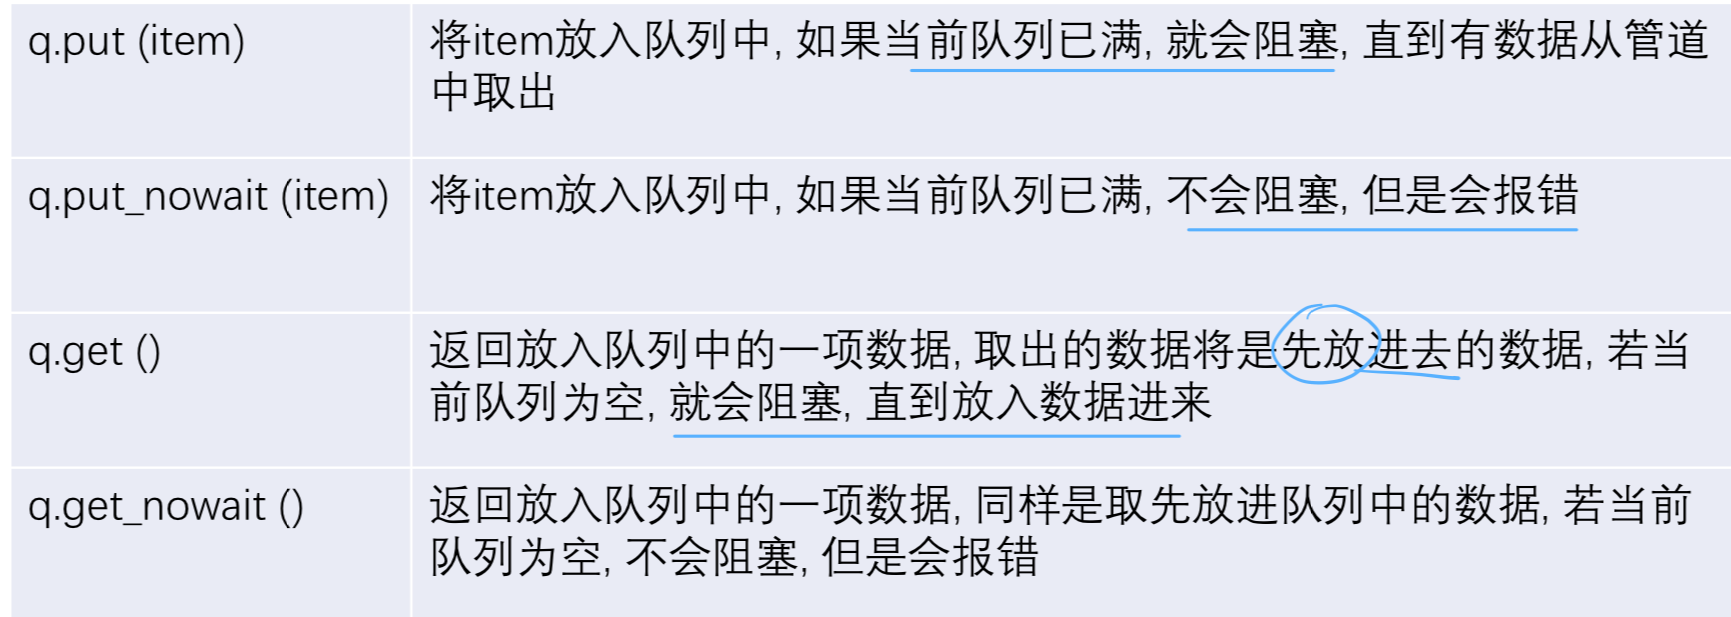s

In [12]:
%%writefile multi_process.py
from multiprocessing import Process,  Queue

def f1(q):
    print('f1 start...') # I/O缓冲区
    q.put([42, None, 'hello'])
    print('f1 end')

def f2(q):
    print('f2 start...')
    info = q.get() # 阻塞，等待消息
    print(info)
    print('f2 end')

if __name__ == '__main__':
    __spec__ = None
    q = Queue()
    p1 = Process(target = f1, args = (q, ))
    p1.start()
    p2 = Process(target = f2, args = (q, ))
    p2.start()
    p1.join()
    p2.join()

Overwriting multi_process.py


In [13]:
%run multi_process.py

f1 start...
f1 end
f2 start...
[42, None, 'hello']
f2 end


* 消息队列的常见应用：生产者-消费者
    * 生产者产生数据
    * 消费者读取数据
    * 数据常常保存在一个消息队列中

In [16]:
%%writefile multi_process.py
from multiprocessing import Process, Queue
import os, time, random, sys

# 生产者进程
def producer(q):
    for value in range(5):
        print('Produce %d' % value)
        sys.stdout.flush()  # 刷新缓冲区
        q.put(value)
        time.sleep(1)

# 消费者进程
def consumer(q):
    while True:
        value = q.get(True)
        print('Consume %d' % value)
        sys.stdout.flush()  # 刷新缓冲区
        time.sleep(1)

if __name__ == '__main__':
    __spec__ = None
    t0 = time.time()
    q = Queue()
    p1 = Process(target=producer, args=(q,))
    p2 = Process(target=consumer, args=(q,))
    p1.start()
    p2.start()
    p1.join()
    p2.terminate()  # 注意，消费者进程中有无限循环，所以需要终止它
    print("Take %ss." % (time.time() - t0))
    sys.stdout.flush()  # 确保主进程的最后输出也被刷新


Overwriting multi_process.py


In [17]:
%run multi_process.py

Produce 0
Consume 0
Produce 1
Consume 1
Produce 2
Consume 2
Produce 3
Consume 3
Produce 4
Consume 4
Take 5.067105054855347s.


### 8.进程类的包装
* 通过封装进程类来个性化进程的运行环境

In [19]:
%%writefile multi_process.py
from multiprocessing import Process
import sys, time

class CustomProcess(Process): # 自定义进程类
    pool = [0, 0] # 每个进程继承独立的副本，因为进程互相独立
    def __init__(self, n, name):
        super().__init__() # 要先执行父类的init方法
        self.n = n
        self.process_name = name

    def run(self): # 在start方法进行后自动运行该方法
        print(f"Process {self.process_name} has the number: {self.n}")
        sys.stdout.flush()
        if CustomProcess.pool[0] == 0:
            CustomProcess.pool[0] = self.n
            CustomProcess.pool[1] += 1
        else:
            print('called')
            sys.stdout.flush()
            CustomProcess.pool[1] = self.n
        print(CustomProcess.pool)
        sys.stdout.flush()

if __name__ == '__main__':
    __spec__ = None
    p1 = CustomProcess(1, name = "Process1")
    p2 = CustomProcess(2, name = "Process2")

    p1.start() # 给os发送创建进程的指令，子进程创建好后执行run方法开始运行
    p2.start()

    p1.join()
    p2.join()

    p1.run()
    p2.run()

    p1.join()
    p2.join()
    
    print("All processes finished.")


Overwriting multi_process.py


In [20]:
%run multi_process.py # strange output

Process Process1 has the number: 1
[1, 1]
Process Process2 has the number: 2
[2, 1]
Process Process1 has the number: 1
[1, 1]
Process Process2 has the number: 2
called
[1, 2]
All processes finished.


### 9.多线程编程
* 代码形式和多进程很类似，共享主线程环境
* python为解释性语言，存在全局解释器，因此在实际执行过程中只能一个一个thread执行，不能实现实质上的并行
* 线程间可以共享全局变量
* 可以用锁（Lock）机制来协调多进程的运行
* 在CPython中由于全局解释器锁（GIL）的存在
    * 全局解释器锁：一个进程任一时刻仅有一个线程在执行
    * 多核CPU并不能为它显著提高效率
        * 可以考虑选择没有GIL的Python解释器（如JPython）

In [23]:
import threading  # 导入threading模块来使用线程
import time       # 导入time模块来使用sleep函数

# 定义一个函数用于线程执行
def greeting(number):
    # 打印当前线程的ID和传入的数字
    print(f'线程ID: {threading.current_thread().name}，任务编号：{number}\n')
    time.sleep(2)   # 令线程睡眠2秒，模拟耗时操作

# 当该脚本作为主程序执行时
if __name__ == '__main__':
    __spec__ = None
    start_time = time.time()  # 记录起始时间
    
    # 创建两个线程对象，target是线程要执行的函数，args是传给函数的参数
    thread1 = threading.Thread(target=greeting, args=(1,))
    thread2 = threading.Thread(target=greeting, args=(2,))
    
    thread1.start()  # 启动第一个线程
    thread2.start()  # 启动第二个线程
    
    thread1.join()   # 等待第一个线程执行完成
    thread2.join()   # 等待第二个线程执行完成

    end_time = time.time()  # 记录结束时间
    print(f"总共耗时 {end_time - start_time:.10f} 秒")  # 打印总耗时


线程ID: Thread-20 (greeting)，任务编号：1
线程ID: Thread-21 (greeting)，任务编号：2


总共耗时 2.0058898926 秒


### 10.互斥锁
* 通过加锁进行资源同步

In [24]:
%%writefile multi_process.py
import time
from multiprocessing import Process, Lock

# 定义一个被多个进程调用的函数
def f(i, lock):
    lock.acquire()  # 获取锁
    try:
        print('hello world', i)
        time.sleep(1)  # 模拟耗时操作
        print(i, "do something.")
    finally:
        pass
        lock.release()  # 释放锁

if __name__ == '__main__':
    __spec__ = None
    lock = Lock()  # 创建一个锁

    # 创建并启动5个进程
    for num in range(5):
        Process(target=f, args=(num, lock)).start()

Overwriting multi_process.py


In [25]:
%run multi_process.py

hello world 2
2 do something.
hello world 4
4 do something.
hello world 0
0 do something.
hello world 3
3 do something.
hello world 1
1 do something.


#### 资源管理器：独占资源同时防止意外死锁

In [26]:
%%writefile multi_process.py
from multiprocessing import Process, Manager

# 定义一个函数，它接收一个字典和一个列表，并修改它们
def modify_shared_objects(shared_dict, shared_list):
    shared_dict[1] = '一'
    shared_dict['二'] = 2
    shared_dict[0.25] = None
    shared_list.reverse()

if __name__ == '__main__':
    __spec__ = None
    # 使用Manager创建共享的数据结构
    with Manager() as manager: # 类似上下文管理器，自动对共享数据结构加/解锁
        shared_dict = manager.dict()
        shared_list = manager.list(range(10))

        # 创建并启动一个进程
        p = Process(target=modify_shared_objects, args=(shared_dict, shared_list))
        p.start()
        p.join()

        # 打印修改后的共享字典和列表
        print(shared_dict)
        print(shared_list)


Overwriting multi_process.py


In [27]:
%run multi_process.py

{1: '一', '二': 2, 0.25: None}
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


### 总结
* 进程：完全独立。通讯要靠系统缓冲区或管道
* 线程：环境不独立
* 要加锁解决冲突问题

## 二、协程与任务分时任务调度
### 1.协程
* 本质上是一个可被异步唤醒的函数
* 存在自阻塞操作（语句）的被动服务函数
* 存在发出调用操作并等待调用返回才继续执行的主动客户方
* 协程的调度由用户程序（而非系统内核）自己来控制（线程是内核调度的最小单元）
#### Python迭代器（可看作协程）

In [28]:
def fib(n):  # 定义一个生成斐波那契数列的生成器函数
    index = 0
    a = 0
    b = 1
    while index < n:
        receive = (yield b)  # 产出当前的斐波那契数，并接收外部传来的值
        print(f'"fib" receive {receive}')  # 打印接收到的值
        a, b = b, a + b  # 计算下一个斐波那契数
        index += 1

fib = fib(20)  # 创建一个生成器函数对象，预定生成20个斐波那契数

# 下面的代码展示了如何通过send方法与生成器交互
# 第一次调用时，生成器尚未启动，所以需要发送None（或者调用next(fib)，二者等效）
print(f'"fib" yield {fib.send(None)}')  # 启动生成器
print()

# 使用send方法发送值1，并打印生成器函数此时产出的斐波那契数
print(f'"fib" yield {fib.send(1)}')
print(f'"fib" yield {fib.send(2)}')
print(f'"fib" yield {fib.send(3)}')
print(f'"fib" yield {fib.send(4)}')


"fib" yield 1

"fib" receive 1
"fib" yield 1
"fib" receive 2
"fib" yield 2
"fib" receive 3
"fib" yield 3
"fib" receive 4
"fib" yield 5


In [29]:
def consumer():
    r = ''
    while True:
        n = yield r  # 生成器暂停并返回r，下次激活时接收外部发送的n
        if not n:
            return
        print('[CONSUMER] Consuming %s...' % n)
        r = '200 OK'  # 消费完成，返回一个结果

def producer(c):
    c.send(None)  # 启动生成器
    n = 0
    while n < 5:
        n = n + 1
        print('[PRODUCER] Producing %s...' % n)
        r = c.send(n)  # 发送n到生成器，同时接收生成器返回的r
        print('[PRODUCER] Consumer return: %s' % r)
    c.close()  # 关闭生成器

c = consumer()  # 创建一个生成器
producer(c)  # 生产者函数开始生产并传递给消费者

[PRODUCER] Producing 1...
[CONSUMER] Consuming 1...
[PRODUCER] Consumer return: 200 OK
[PRODUCER] Producing 2...
[CONSUMER] Consuming 2...
[PRODUCER] Consumer return: 200 OK
[PRODUCER] Producing 3...
[CONSUMER] Consuming 3...
[PRODUCER] Consumer return: 200 OK
[PRODUCER] Producing 4...
[CONSUMER] Consuming 4...
[PRODUCER] Consumer return: 200 OK
[PRODUCER] Producing 5...
[CONSUMER] Consuming 5...
[PRODUCER] Consumer return: 200 OK


In [30]:
def gen_cal(): # 一个有隐含功能的迭代器
    x = 1
    y = 1
    exp = None
    while x < 256:
        if exp == None:  # 初始状态或者执行完表达式
            x, y = y, x+y
            exp = yield y  # 产出y，暂停执行
        else:
            exp = yield (eval(exp))  # 计算表达式的结果，并产出

gc = gen_cal()  # 创建一个生成器对象

print(next(gc))  # 启动生成器，打印 2 （next其实会发送none）
print(next(gc))  # 打印 3
print(gc.send('23+9/3.0'))  # 发送表达式 '23+9/3.0' 给生成器，计算并打印结果 26.0
print(next(gc))  # 继续生成器，打印下一个斐波那契数 5

2
3
26.0
5


#### 任务轮转调度：用协程实现

In [31]:
# 定义一个任务1的生成器函数
def task1():
    timeN = 12
    dur = 6
    # 当任务时间大于0时，持续运行
    while timeN > 0:
        timeN -= dur
        print('Task1 need:', timeN)
        yield timeN  # 产出当前需要的时间，并暂停执行
    print('Task 1 Finished')

# 定义一个任务2的生成器函数
def task2():
    timeN = 11
    dur = 3
    # 当任务时间大于0时，持续运行
    while timeN > 0:
        timeN -= dur
        print('Task2 need:', timeN)
        yield  # 产出空值，并暂停执行（只交出运行权，不返回值）
    print('Task 2 Finished')

# 定义一个轮询调度函数
def RoundRobin(*task):
    tls = list(task)
    # 当任务列表不为空时，持续运行
    while len(tls) > 0:
        for p in tls:
            try:
                next(p)  # 尝试执行下一个任务的下一个步骤
            except StopIteration:
                tls.remove(p)  # 如果任务已完成，则从列表中移除
    print('All finished! 可以歇一会了')

# 初始化任务1和任务2的生成器
t1 = task1() # 还可以输入控制参数
t2 = task2()

# 执行轮询调度
RoundRobin(t1, t2)


Task1 need: 6
Task2 need: 8
Task1 need: 0
Task2 need: 5
Task 1 Finished
Task2 need: 2
Task2 need: -1
Task 2 Finished
All finished! 可以歇一会了


### 2.回调函数（call back）
* 在函数中调用一个作为参数传入的函数

In [30]:
# 定义一个回调函数
def demo_callback(st):
    print(st)

# 定义一个执行回调的函数
def caller(args, func):
    print('Caller: Do something.')  # 表明caller函数正在做某事
    func(args)  # 调用回调函数

# 执行函数，将字符串和回调函数作为参数传入
caller('I am callee.', demo_callback)

Caller: Do something.
I am callee.


#### 利用回调函数实现函数的功能组合

In [33]:
# 定义处理函数，接收一个函数和参数，以及一个回调函数
def demo_handle(func, args, callback): # 类似于句柄
    # 使用提供的参数调用函数，并获取结果
    result = func(*args)
    # 调用回调函数，并将结果和函数的名称传递给它
    callback(result, func.__name__)

# 定义一个加法函数
def add(x, y):
    return x + y

# 定义一个通知函数，作为回调函数使用
def notify(result, frm):
    # 打印调用函数的名称和结果
    print('Call function {} result = {}'.format(frm, result))

# 调用处理函数，传递加法函数、参数和回调函数作为参数
demo_handle(add, (3, 5), callback=notify)

explain = '''
demo_handle函数不需要关心func和callback的具体实现，只要它们接口符合预期
（即func能够接收一定的参数，callback能够接收结果和函数名作为参数），
demo_handle就可以用来将任意这样的func和callback组合起来。
'''

Call function add result = 8


In [34]:
# 定义一个异步应用函数，它接受一个函数、参数和回调生成器
def apply_async(func, args, *, callback):
    # 计算函数结果
    result = func(*args)
    # 向回调生成器发送结果
    callback.send(result)

# 定义两个简单的函数进行数学运算
def add(x, y):
    return x + y

def times(x, y):
    return x * y

# 定义一个生成器函数（协程），用于创建回调处理器
def make_handler():
    counter = 0  # 初始化计数器
    while True:
        # 生成器暂停，并等待外部发送结果
        result = yield
        counter += 1  # 更新计数器
        # 打印接收到的计数和结果
        print(f"counter = {counter} result: {result}")

# 创建回调处理器实例
handle = make_handler()
# 激活生成器
next(handle)

# 异步调用add函数，并传入回调处理器
apply_async(add, (3, 5), callback=handle) # handle可以是多种不同的I/O设备
# 异步调用times函数，并传入回调处理器
apply_async(times, (3, 5), callback=handle)

explain = '''
在实际应用中，这样的模式可以被用于异步编程，特别是在事件驱动或并发编程中。通过生成器，我们可以控制函数执行的流程，暂停和继续执行。
这里的apply_async模拟异步调用，而make_handler生成器则作为一个协程来处理异步调用的结果。
这样的结构可以让我们轻松地在单个线程中管理多个异步操作的状态和结果，而不需要使用复杂的线程或进程同步机制。
'''

counter = 1 result: 8
counter = 2 result: 15


In [35]:
def apply_handler(func, args, *, callback): # 异步框架函数，用来协调运行，隔离计算和I/O
    result = func(*args) # 计算
    callback(result) # 把要I/O的任务交给回调函数

def add(x, y):
    return x + y
    
def times(x, y):

    return x * y

def make_handler(): # 函数装饰器 handler（句柄）
    counter = 0
    
    def handler(result): # 把要进行的任务包装一下，加入日志，结果输出...
        nonlocal counter
        counter += 1
        print(f"counter = {counter} result: {result}")

    return handler

handler = make_handler() # 具备管理全局信息（如调用次数）的功能

apply_handler(add, (2, 3), callback=handler)
apply_handler(times, (4, 6), callback=handler)


counter = 1 result: 5
counter = 2 result: 24


#### 轮转调度队列中的协程

In [36]:
# 全局等待列表
waiting_list = []

# 简单的Handle
class PrimitiveHandle(object): # 可以对准备调度的任务进行包装，如设置时间片大小、优先级、最大运行时间...
    # 初始化时传入一个生成器
    def __init__(self, gen):
        self.gen = gen

    # 调用生成器的下一个元素，并将自己添加到等待列表中
    def call(self):
        next(self.gen) # 被调度上cpu后执行一个时间片
        waiting_list.append(self) # 再把自己放回去

# 简单的轮询调度函数
def PrimitiveRoundRobin(tasks):
    # 将任务包装为Handle对象，并加入等待列表
    waiting_list.extend(PrimitiveHandle(c) for c in tasks)

    # 当等待列表不为空时，循环调用列表中的Handle对象
    while waiting_list:
        for p in waiting_list:
            try:
                p.call()
            except StopIteration:
                # 一旦某个任务完成，将其从等待列表中移除
                waiting_list.remove(p)

    print('All finished! 可以休息一会了')
    
# 任务1
def task1():
    timeN = 12
    dur = 6
    while timeN > 0:
        timeN -= dur
        print('Task1 need:', timeN)
        yield timeN
    print('Task 1 Finished')

# 任务2
def task2():
    timeN = 11
    dur = 3
    while timeN > 0:
        timeN -= dur
        print('Task2 need:', timeN)
        yield
    print('Task 2 Finished')

if __name__ == '__main__':
    # 简单的轮询调度
    PrimitiveRoundRobin([task1(), task2()])

Task1 need: 6
Task2 need: 8
Task1 need: 0
Task2 need: 5
Task 1 Finished
Task2 need: 2
Task2 need: -1
Task 2 Finished
All finished! 可以休息一会了


In [37]:
# 全局等待列表
waiting_list = []

# 复杂的Handle
class SophisticatedHandle(object): # 可以对准备调度的任务进行包装，如设置时间片大小、优先级、最大运行时间...
    # 初始化时传入一个生成器
    def __init__(self, gen, pri = 0.5):
        self.gen = gen
        self.timeSlice = 0
        self.timeNeed = 0
        self.pr = pri # 优先级，pr<1，越高运行的时间片越长

    # 调用生成器的下一个元素，并将自己添加到等待列表中
    def call(self):
        try:
            if self.timeSlice == 0:
                self.timeNeed = next(self.gen) # 首次调用接收到完成任务所需时间
                self.timeSlice = int(self.timeNeed * self.pr)
            else:
                # print('called')
                self.gen.send(self.timeSlice) # 运行，并且设置下一个时间片长度
            waiting_list.append(self) # 再把自己放回去
        except StopIteration:
            print(self.gen.__name__, 'finished')

# 复杂的轮询调度函数
def SophisticatedRoundRobin(tasks):
    # 将任务包装为Handle对象，并加入等待列表
    waiting_list.extend(SophisticatedHandle(c) for c in tasks)

    # 当等待列表不为空时，循环调用列表中的Handle对象
    while waiting_list:
        p = waiting_list.pop(0) # 从队头弹出一个Handle
        p.call()
        
    print('All finished! 可以休息一会了')

# 任务1
def task1():
    timeN = 12
    while timeN > 0:
        timeSlice = yield timeN  
        if timeSlice == None:
            timeSlice = 0
        timeN -= timeSlice
        print('Task1 need:', timeN, 'and Time slice = ', timeSlice)
    
# 任务2
def task2():
    timeN = 11
    while timeN > 0:
        timeSlice = yield timeN
        if timeSlice == None:
            timeSlice = 0
        timeN -= timeSlice
        print('Task2 need:', timeN, 'and Time slice = ', timeSlice)

if __name__ == '__main__':
    # 复杂的轮询调度
    SophisticatedRoundRobin([task1(), task2()])

Task1 need: 6 and Time slice =  6
Task2 need: 6 and Time slice =  5
Task1 need: 0 and Time slice =  6
task1 finished
Task2 need: 1 and Time slice =  5
Task2 need: -4 and Time slice =  5
task2 finished
All finished! 可以休息一会了


### 3.事件循环机制
#### 用asyncio/await实现协程
* Python 3.5后 async/await 用于定义协程的关键字
  * 不用先next，直接可以send调用
  * yield from替换为await
  * 在一个协程内部，当你 await 一个表达式时，Python 会暂停该协程的执行，直到等待的表达式完成。期间，事件循环将继续运行，这样其他操作就不会因为一个操作的等待而被阻塞

In [39]:
%%writefile co-routine.py
import asyncio
import time

# 定义一个异步函数，延迟一段时间后打印信息
async def say_after(delay, what): # 定义异步awaitable object
    await asyncio.sleep(delay)
    print(what)

# 定义主要的异步函数
async def main():
    print(f"started at {time.strftime('%X')}")

    # 异步等待say_after函数完成
    await say_after(1, 'hello') # 在一个已经运行的协程中等待响应
    await say_after(2, 'world')

    print(f"finished at {time.strftime('%X')}")

# 运行主函数
asyncio.run(main()) # 执行协程（创建一个依附于线程的事件循环）v3.7+

Overwriting co-routine.py


In [50]:
%%writefile co-routine.py
import asyncio
import time

# 定义异步函数say_after
async def say_after(delay, what):
    await asyncio.sleep(delay)
    print(what)

# 定义主异步函数
async def main():
    print(f"started at {time.strftime('%X')}")

    # 使用 asyncio.create_task 来创建任务
    # 这将 coroutine 封装为一个将被并发执行的 task
    task1 = asyncio.create_task(say_after(3, 'hello'))

    task2 = asyncio.create_task(say_after(1, 'world'))

    # 等待任务完成
    await task1 # world会先输出，等待任务完成不代表cpu只执行该任务，os仍然会调度
    await task2

    print(f"finished at {time.strftime('%X')}")

# 运行主函数
asyncio.run(main()) # 依附于线程main的事件循环

Overwriting co-routine.py


In [52]:
%%writefile co-routine.py
import asyncio
import time

# 定义一个异步函数，模拟长时间运行的任务
async def eternity():
    # 模拟一个持续一小时的任务
    await asyncio.sleep(3600)
    print('yay!')

# 主函数
async def main():
    # 设置一个最多等待一秒的超时
    try:
        # 使用 asyncio.wait_for 来设置超时时间
        await asyncio.wait_for(eternity(), timeout=1.0) # 只等1s
    except asyncio.TimeoutError:
        # 如果超时则打印 'timeout!'
        print('timeout!')

# 运行主函数
asyncio.run(main())


Overwriting co-routine.py


#### 事件循环队列

In [40]:
%%writefile co-routine.py
import asyncio
import datetime
import time

# 定义四个函数，它们将被作为事件循环中的回调函数

def function_1(end_time, loop):
    print('function_1 called')
    if (loop.time() + 1.0) < end_time:
        loop.call_later(1, function_2, end_time, loop) # 睡眠1s后再调用function_2
    else:
        loop.stop()

def function_2(end_time, loop):
    print('function_2 called')
    if (loop.time() + 1.0) < end_time:
        loop.call_later(1, function_3, end_time, loop)
    else:
        loop.stop()

def function_3(end_time, loop):
    print('function_3 called')
    if (loop.time() + 1.0) < end_time:
        loop.call_later(1, function_1, end_time, loop)
    else:
        loop.stop()

def function_4(end_time, loop):
    print('function_4 called')
    if (loop.time() + 1.0) < end_time:
        loop.call_later(1, function_1, end_time, loop) # 睡眠1s后再调用function_1
    else:
        loop.stop()

# 获取当前事件循环
loop = asyncio.get_event_loop()

# 定义结束时间为当前时间加上9秒
end_time = loop.time() + 9.0

# 在事件循环中注册function_4函数作为初始调用
loop.call_soon(function_4, end_time, loop) # 尽快执行

# 运行事件循环，直到stop()被调用
loop.run_forever()

# 关闭事件循环
loop.close()


Overwriting co-routine.py


#### 用事件循环队列实现生产者-消费者异步流程

In [12]:
%%writefile co-routine.py
import asyncio, time

async def consumer(q):
    print('consumer starts.')
    while True:
        item = await q.get()  # 从队列中获取一个项目

        if item is None:
            # None是停止信号
            q.task_done()
            break
        else:
            # 模拟消费项目需要的时间
            await asyncio.sleep(1)
            print(f'consume {item}')
            q.task_done()  # 表示前面的get()任务完成

    print('consumer ends.')

# 定义异步生产者函数
async def producer(q):
    print('producer starts.')
    for i in range(5):
        # 模拟生产项目需要的时间
        await asyncio.sleep(1)
        print(f'produce {i}')
        await q.put(i)  # 将一个项目放入队列

    await q.put(None)  # 放入None作为消费者停止的信号

    await q.join() # 阻塞直到队列中所有的item都被取走
    print('producer ends.')

async def main():
    # 创建一个队列
    q = asyncio.Queue(maxsize=10)
    # 创建任务而不是直接传递协程（在 Python 3.11 中，必须显式地创建任务）
    producer_task = asyncio.create_task(producer(q))
    consumer_task = asyncio.create_task(consumer(q))
    await asyncio.gather(producer_task, consumer_task)

# 使用时间来度量程序运行的总时间
t0 = time.time()

asyncio.run(main())

# 输出程序运行的总时间
print(time.time() - t0, "s")


Overwriting co-routine.py


### 总结
* 协程之间不是并发/并行的关系，在同一线程中顺序执行
* 协程在逻辑上倾向于一个功能独立的例程
* 可以被反复调用并在被调用过程中保持内部状态，直到异常中断或自行退出
* 常用于I/O通讯，资源管理与操作响应等